In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta as ta
import os
import datetime
import json
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbtpro as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from bband import get_data,Strategy

### 樣本內全參數 (多、空)

In [35]:
import ast
import pandas as pd
import hiplot as hip

def insample_params_highland(coin:str, freq: str, direction: str):
    params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
    params_df['params'] = params_df['params'].apply(ast.literal_eval)
    temp_df = params_df['params'].apply(pd.Series)
    df = pd.concat([params_df.drop(columns='params'), temp_df], axis=1)
    target = df[['window_l_k','window_l_d','window_s_k','window_s_d','Sharpe Ratio','Calmar Ratio','Win Rate [%]']]
    data_for_hiplot = target.to_dict(orient='records')
    exp = hip.Experiment.from_iterable(data_for_hiplot)
    exp.display(force_full_width=False, width=400, height=100)


In [1]:
import pandas as pd
import json

symbol_list = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               '1000PEPE','LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR','STORJ',
               '1000FLOKI','MKR','CYBER','UNI','STRAX',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']

params_dict = {}
for freq in ['5T','15T','1h','4h']:
    params_dict[freq] = {}
    for coin in symbol_list:
        params_dict[freq][coin] = {}
        for direction in ['long','short']:
            params_dict[freq][coin][direction] = {}
            i = 0
            try:
                params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
                for _ , row in params_df[params_df['Sharpe Ratio']>2].iterrows():
                    params_dict[freq][coin][direction][str(i)] = row['params']
                    i += 1
            except Exception as e:
                pass
        try:
            if len(params_dict[freq][coin]['long'])==0 or len(params_dict[freq][coin]['short']==0):
                params_dict[freq].pop(coin)
        except:
            pass
            
filename = "params.json"

with open(filename, 'w') as file:
    json.dump(params_dict, file, indent=4)

### 樣本外
取樣本內前一半參數來看樣本外表現


In [5]:
df_dict = {}
# candidate = ['AVAX','STRAX','BLUR','WAVES','MASK','NEO','FET','STX',
#              'SOL','MATIC','DYDX','AVAX','LINK','TRB','WLD','ADA','OP','RUNE',
#             'ARB','GMT','ETC','LDO','GALA','APE','FTM','APT','NEAR']
# for coin in candidate:
#     df_dict[coin] = get_data(coin)

In [6]:
from tqdm.auto import tqdm
start = '2022-01-01'
sep = ''
end = ''

def outample_params_highland(freq, side, coin):
    outsample_record = []
    params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
    for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
        params = eval(row['params'])
        config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
        df = df_dict[coin]
        strategy = Strategy(df=df.loc[start:], configs=config)
        analyze = Analyzer(strategy)
        mdd, stat = analyze.outsample_result_gen(params, side, coin, axv_index=['2023-05-01'])
        params['mdd'] = mdd
        params['sharpe'] = stat['Sharpe Ratio']
        params['calmar'] = stat['Calmar Ratio']
        params['win rate'] = stat['Win Rate [%]']
        outsample_record.append(params)
    exp = hip.Experiment.from_iterable(outsample_record)
    exp.display()


In [8]:
def in_out_test(freq, coin):
    for direction in ['long','short']:
        outsample_record = []
        params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
        for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
            params = eval(row['params'])
            config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
            try:
                df = df_dict[coin]
            except:
                df_dict[coin] = pd.read_hdf(f'/Volumes/crypto_data/price_data/binance/1m/{coin}USDT_PERPETUAL.h5')
                df = df_dict[coin]            
            strategy = Strategy(df=df.loc[start:], configs=config)
            analyze = Analyzer(strategy)
            mdd, stat = analyze.outsample_result_gen(params, direction, coin, axv_index=['2023-05-01'])
            params['mdd'] = mdd
            params['sharpe'] = stat['Sharpe Ratio']
            params['calmar'] = stat['Calmar Ratio']
            params['win rate'] = stat['Win Rate [%]']
            outsample_record.append(params)
        max_sharpe = 0
        for i in range(len(outsample_record)):
            if outsample_record[i]['sharpe'] > max_sharpe:
                max_sharpe = outsample_record[i]['sharpe']
                best_params = outsample_record[i]
        if max_sharpe > 2:
            strategy = Strategy(df=df.loc[start:], configs=config)
            _pf = strategy.strategy(side = direction,params=params)
            analyze = Analyzer(strategy)
            analyze.show_pf_analysis(dict(list(best_params.items())[:2]), direction, coin, axv_index=['2023-05-01'])

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APY: 50.64 %
MDD: 8.21 %
MDD Duration 135 days 19:00:00
worst trade: -2.92 %
2022-05-13 07:45:00 ~ 2022-05-13 21:45:00
avg holding days: 0.11 days
--------------------------------------------
PF: 1.47
Sharpe Ratio: 2.05
Calmar Ratio: 5.20
Sortino Ratio: 3.16
Omega Ratio: 1.13
--------------------------------------------
Expectancy : 0.18 %
Total Time Exposure : 8.53 %
Total Trades: 543
Win Rate: 23.76 %
--------------------------------------------
PF * Win Rate: 0.350


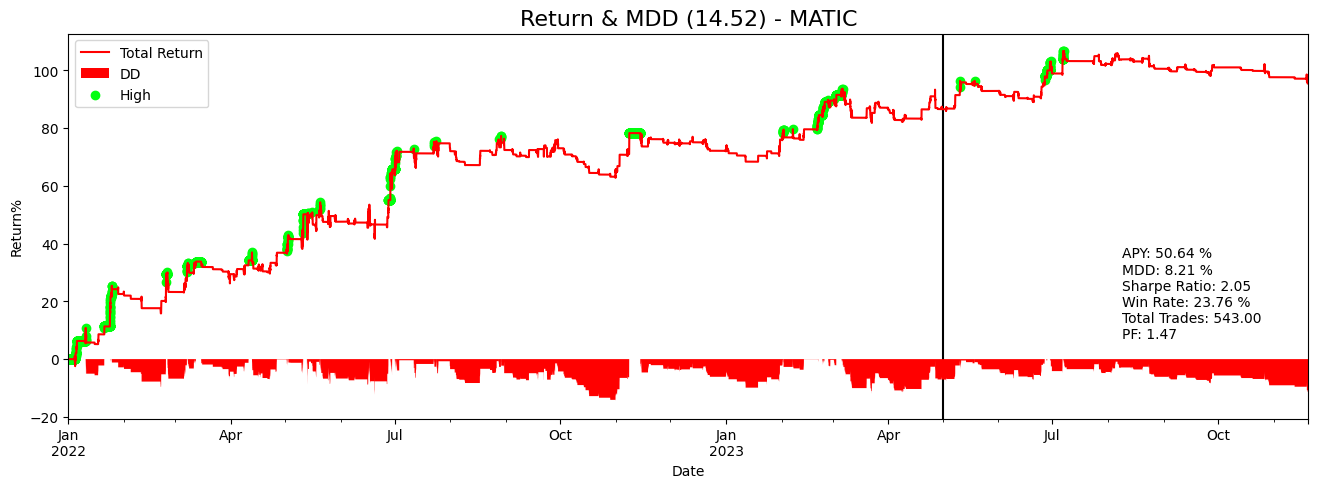

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APY: 65.70 %
MDD: 16.42 %
MDD Duration 258 days 02:30:00
worst trade: -4.89 %
2023-08-17 21:45:00 ~ 2023-08-17 22:00:00
avg holding days: 0.13 days
--------------------------------------------
PF: 1.66
Sharpe Ratio: 2.11
Calmar Ratio: 3.25
Sortino Ratio: 3.29
Omega Ratio: 1.13
--------------------------------------------
Expectancy : 0.28 %
Total Time Exposure : 8.39 %
Total Trades: 449
Win Rate: 22.27 %
--------------------------------------------
PF * Win Rate: 0.370


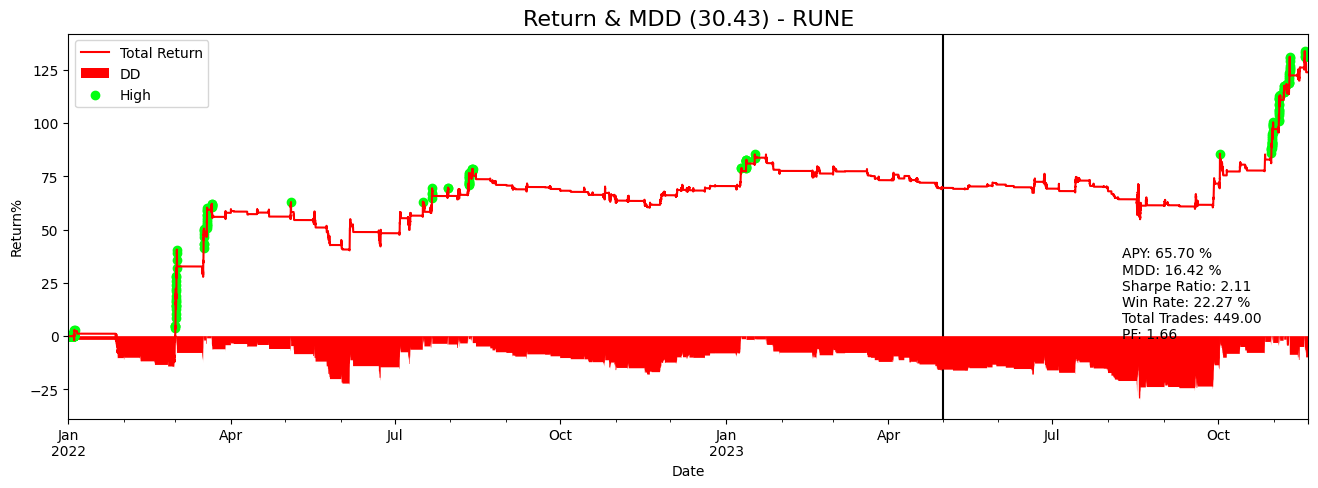

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APY: 50.64 %
MDD: 21.27 %
MDD Duration 150 days 21:15:00
worst trade: -4.36 %
2023-06-30 11:45:00 ~ 2023-06-30 13:30:00
avg holding days: 0.12 days
--------------------------------------------
PF: 1.50
Sharpe Ratio: 2.04
Calmar Ratio: 2.57
Sortino Ratio: 3.28
Omega Ratio: 1.13
--------------------------------------------
Expectancy : 0.19 %
Total Time Exposure : 8.70 %
Total Trades: 180
Win Rate: 15.56 %
--------------------------------------------
PF * Win Rate: 0.233


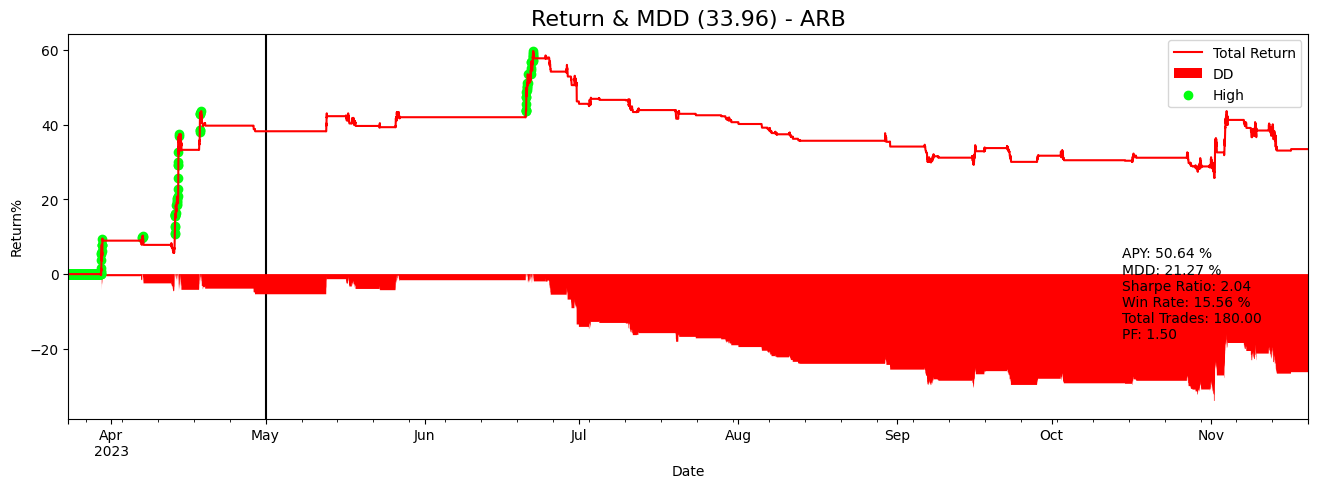

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APY: 92.48 %
MDD: 13.13 %
MDD Duration 125 days 16:30:00
worst trade: -3.56 %
2023-05-22 12:00:00 ~ 2023-05-22 12:30:00
avg holding days: 0.15 days
--------------------------------------------
PF: 1.79
Sharpe Ratio: 2.42
Calmar Ratio: 5.68
Sortino Ratio: 4.06
Omega Ratio: 1.17
--------------------------------------------
Expectancy : 0.37 %
Total Time Exposure : 10.37 %
Total Trades: 425
Win Rate: 22.12 %
--------------------------------------------
PF * Win Rate: 0.396


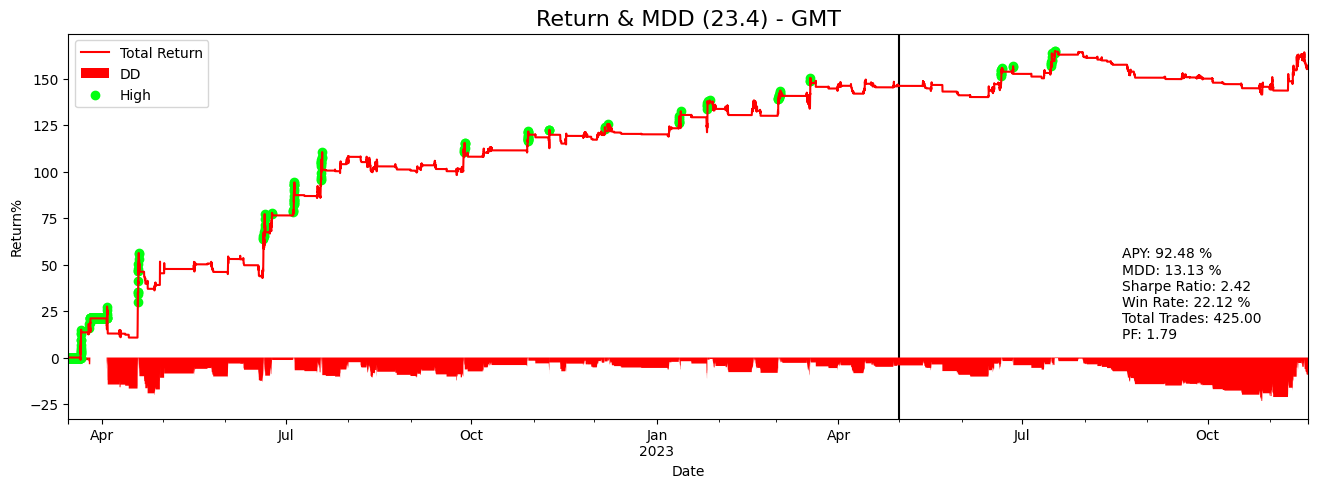

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APY: 85.80 %
MDD: 9.50 %
MDD Duration 113 days 22:45:00
worst trade: -3.71 %
2023-01-18 20:45:00 ~ 2023-01-18 23:30:00
avg holding days: 0.15 days
--------------------------------------------
PF: 1.97
Sharpe Ratio: 2.14
Calmar Ratio: 8.75
Sortino Ratio: 3.89
Omega Ratio: 1.17
--------------------------------------------
Expectancy : 0.41 %
Total Time Exposure : 8.69 %
Total Trades: 227
Win Rate: 20.70 %
--------------------------------------------
PF * Win Rate: 0.409


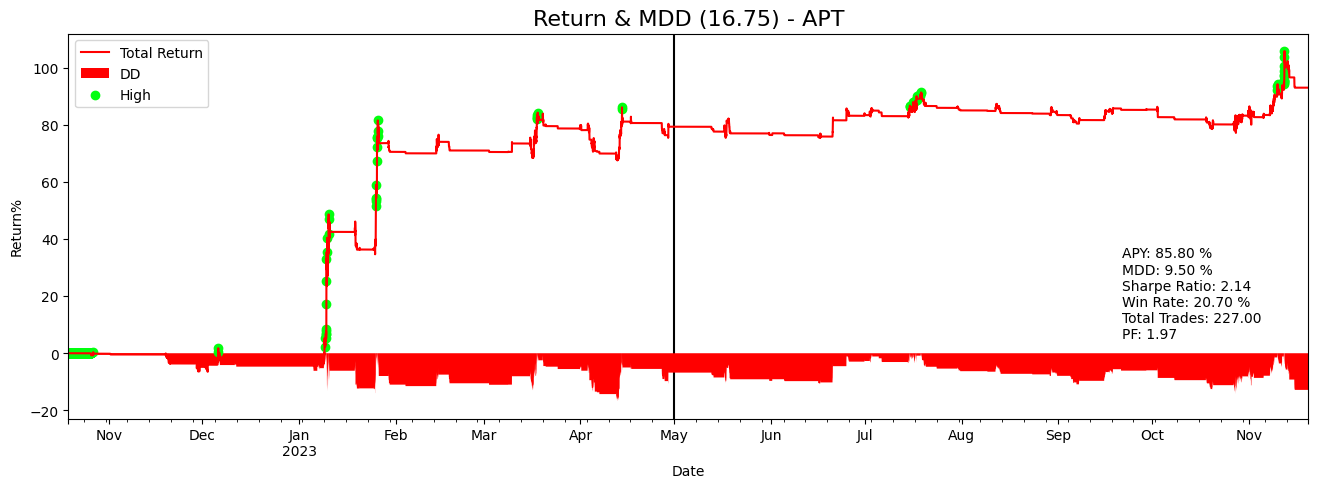

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

In [16]:
for coin in ['MATIC','RUNE','ARB','GMT','APT']:
    try:
        in_out_test('15T', coin)
    except Exception as e:
        print(e)

4h : BTC,DYDX,TRB,ADA,RUNE,INF,FTM,SUSHI,EGLD,FET,GRT,STX,XLM
1h : BLUR,FET,SOL,DYDX,TRB,OP,RUNE,ARB,GMT,LDO,APT,NEAR
15T : MATIC,RUNE,ARB,GMT,APT


In [12]:
import hiplot as hip
freq = '15T'
for direction in ['long','short']:
    print(f'-------------------------frequency:{freq}----------------------direction:{direction}---------------------')
    outample_params_highland('15T', direction, 'AVAX')


-------------------------frequency:15T----------------------direction:long---------------------


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

-------------------------frequency:15T----------------------direction:short---------------------


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 挑選參數全樣本結果

APY: 128.45 %
MDD: 15.98 %
MDD Duration 95 days 01:00:00
worst trade: -10.75 %
2022-09-07 04:00:00 ~ 2022-09-09 03:00:00
avg holding days: 5.29 days
--------------------------------------------
PF: 2.64
Sharpe Ratio: 2.16
Calmar Ratio: 5.79
Sortino Ratio: 3.26
Omega Ratio: 1.10
--------------------------------------------
Expectancy : 2.47 %
Total Time Exposure : 75.38 %
Total Trades: 97
Win Rate: 52.58 %
--------------------------------------------
PF * Win Rate: 1.385


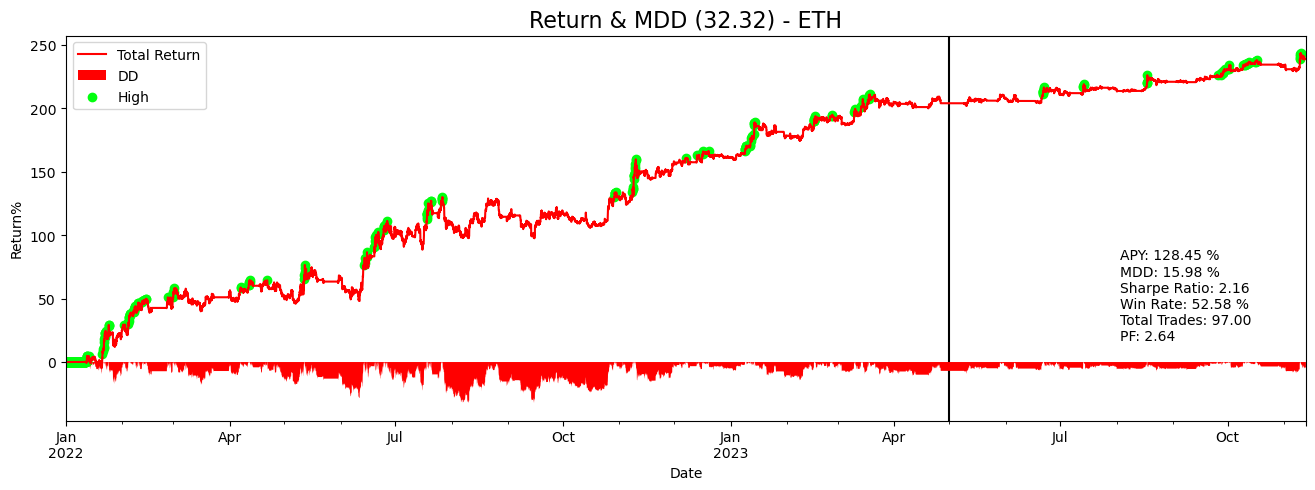

(None,
 Start                               2022-01-01 00:00:00
 End                                 2023-11-12 23:00:00
 Period                                681 days 00:00:00
 Start Value                                     10000.0
 Min Value                                   9524.910264
 Max Value                                  34363.056868
 End Value                                  33929.683914
 Total Return [%]                             239.296839
 Benchmark Return [%]                         -44.573538
 Total Time Exposure [%]                       75.379344
 Max Gross Exposure [%]                        108.13714
 Max Drawdown [%]                              15.981857
 Max Drawdown Duration                  95 days 01:00:00
 Total Orders                                        185
 Total Fees Paid                              582.121873
 Total Trades                                         97
 Win Rate [%]                                   52.57732
 Best Trade [%]         

In [3]:
start = '2022-01-01'
sep = ''
end = ''

side = 'both'

params = {'window_l_k': 48, 'window_l_d': 132, 'window_s_k': 52, 'window_s_d': 140}
# sol 1h : 40,48,100,126,95 original
config = {'freq':'1h', 'lag':1, 'fee': 0.0003}
coin = 'ETH'
df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
analyze.show_pf_analysis(params, side, coin, axv_index=['2023-05-01'])